# FORECASTING KENYA ELECTRICITY DEMAND WITH ML MODELS

# GROUP MEMBERS 
Abigael Musyoka,
Marylyne ingwe,
Elizabeth Kiilu,
Pauline Kimenzu,
MaryBennah Kuloba,
Ray Onsongo, 
Kennedy Wamwati.

## PROJECT OVERVIEW
This project proposes a machine learning solution to forecast daily electricity demand in Kenya, where demand is growing 5–7% annually due to urbanization and industrialization. The goal is to provide accurate short-term predictions to support grid reliability, optimize power generation, and facilitate renewable energy integration

## 1. BUSINESS UNDERSTANDING

This project aims to analyze and forecast Kenya’s national electricity demand (measured in GWh daily) by examining its relationships with climatic variables such as temperature, rainfall, and humidity, alongside macroeconomic indicators like GDP and population growth. The topic is crucial because Kenya, like many growing economies, faces significant challenges in balancing energy supply with increasing demand, which is influenced by seasonal weather patterns, economic activity, and demographic shifts. This study applies to the energy and utilities sector, with a focus on grid planning and energy policy. The target audience includes energy planners, policymakers, utility companies, and investors in Kenya’s power sector. If implemented, the insights from this analysis could enhance demand forecasting accuracy, support resilient grid management, inform infrastructure investments, and contribute to more efficient and reliable electricity provision—ultimately supporting economic stability and growth. This work builds upon existing research in energy demand modeling, climate-impact studies, and econometric forecasting, leveraging historical data to uncover actionable patterns for sustainable energy planning.

## 2. DATA UNDERSTANDING 

This is a consolidated daily time-series dataset for Kenya, covering the period from January 2022 to June 2024. The core focus is the target variable demand_gwh_daily, which represents the daily national electricity demand in Gigawatt-hours (GWh). This target is accompanied by weather variables (temp_c_synthetic, rainfall_mm_synthetic, humidity_pct_synthetic), temporal features (date, year, month, weekday, is_weekend, season), and slow-changing macro indicators (gdp_current_usd_billion, population_total). The data is aggregated at the national level, with static geographical coordinates. A notable observation is the presence of missing data in early years for the forecast uncertainty columns (demand_low_gwh_daily, demand_high_gwh_daily), which are only populated from 2024 onward, suggesting a change in data collection or methodology. The demand_gwh column appears to be a yearly cumulative total, repeated for each day within the same year. Initial inspection reveals clear weekly seasonality, with lower demand on weekends (is_weekend=TRUE), and evidence of annual seasonality through the season variable (e.g., long_rains, cool_dry). This structure is suitable for time-series analysis and regression modeling to understand how daily weather fluctuations and long-term economic/demographic trends drive electricity consumption patterns in Kenya.

In [4]:
# importing relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler



pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

#load dataset
df = pd. read_csv('kenya_daily_demand_weather_gdp_population_NATIONAL_2022_2027-consolidated.csv')

#review of first 5 rows
df.head()

,date,year,month,weekday,is_weekend,season,demand_gwh_daily,demand_low_gwh_daily(5%),demand_high_gwh_daily(7%),demand_gwh,demand_low_gwh(5%),demand_high_gwh(7%),gdp_current_usd_billion,population_total,temp_c_synthetic,rainfall_mm_synthetic,humidity_pct_synthetic,lat,lon,country,aggregation
0,1/1/2022,2022,1,Saturday,True,short_dry,26.597,NaN,NaN,10008.0,NaN,NaN,113.42,54241584,24.07,1.52,55.3,-0.023559,37.906193,Kenya,national
1,1/2/2022,2022,1,Sunday,True,short_dry,26.597,NaN,NaN,10008.0,NaN,NaN,113.42,54241584,26.72,2.11,51.0,-0.023559,37.906193,Kenya,national
2,1/3/2022,2022,1,Monday,False,short_dry,27.419,NaN,NaN,10008.0,NaN,NaN,113.42,54241584,26.45,2.48,55.0,-0.023559,37.906193,Kenya,national
3,1/4/2022,2022,1,Tuesday,False,short_dry,27.419,NaN,NaN,10008.0,NaN,NaN,113.42,54241584,22.98,2.70,56.5,-0.023559,37.906193,Kenya,national
4,1/5/2022,2022,1,Wednesday,False,short_dry,27.419,NaN,NaN,10008.0,NaN,NaN,113.42,54241584,23.40,2.89,59.1,-0.023559,37.906193,Kenya,national


In [5]:
#To check the shape of the dataset

print("Shape:", df.shape)

df.info()

# 2191 rowa and 21 columns

Shape: (2191, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       2191 non-null   object 
 1   year                       2191 non-null   int64  
 2   month                      2191 non-null   int64  
 3   weekday                    2191 non-null   object 
 4   is_weekend                 2191 non-null   bool   
 5   season                     2191 non-null   object 
 6   demand_gwh_daily           2191 non-null   float64
 7   demand_low_gwh_daily(5%)   1461 non-null   float64
 8   demand_high_gwh_daily(7%)  1461 non-null   float64
 9   demand_gwh                 2191 non-null   float64
 10  demand_low_gwh(5%)         1461 non-null   float64
 11  demand_high_gwh(7%)        1461 non-null   float64
 12  gdp_current_usd_billion    2191 non-null   float64
 13  population_total           219

In [6]:
# Data Handling

# Change the dtype for date

df["date"] = pd.to_datetime(df["date"])

df = df.sort_values("date").reset_index(drop=True)

df[["date", "year", "month", "weekday"]].head()


,date,year,month,weekday
0,2022-01-01,2022,1,Saturday
1,2022-01-02,2022,1,Sunday
2,2022-01-03,2022,1,Monday
3,2022-01-04,2022,1,Tuesday
4,2022-01-05,2022,1,Wednesday


In [7]:
# Missing Values Analysis

missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


demand_high_gwh_daily(7%)    730
demand_low_gwh(5%)           730
demand_high_gwh(7%)          730
demand_low_gwh_daily(5%)     730
dtype: int64

In [8]:
# Percentage of missing values

missing_percent = (missing / len(df)) * 100
missing_percent[missing_percent > 0]


demand_high_gwh_daily(7%)    33.31812
demand_low_gwh(5%)           33.31812
demand_high_gwh(7%)          33.31812
demand_low_gwh_daily(5%)     33.31812
dtype: float64

In [9]:
# Checking for duplicates

df.duplicated().sum()
# no duplicates

np.int64(0)

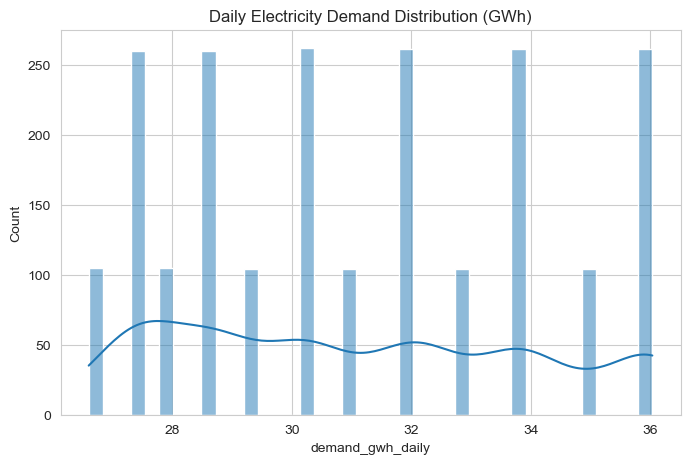

In [10]:
# Target Variable Analysis -Demand

#Daily Demand Distribution

plt.figure(figsize=(8,5))
sns.histplot(df["demand_gwh_daily"], bins=40, kde=True) #smooth kde shows a continous change in demand with no structural breaks/spikes
plt.title("Daily Electricity Demand Distribution (GWh)")
plt.show()


The daily electricity demand most commonly falls between 30 and 34 GWh, with peak frequency around 32 GWh. Demand is very rarely below 28 GWh or above 36 GWh.

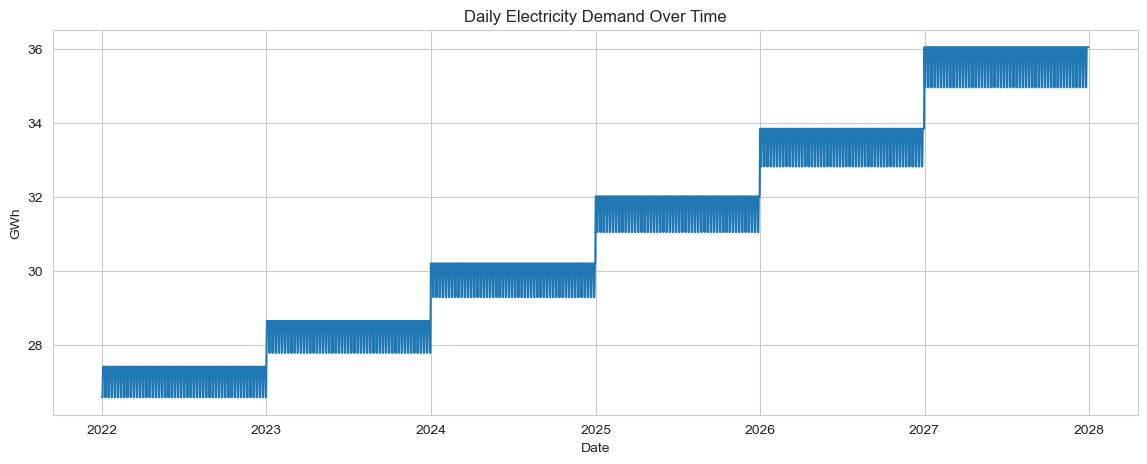

In [11]:
# Time series View

plt.figure(figsize=(14,5))
plt.plot(df["date"], df["demand_gwh_daily"])
plt.title("Daily Electricity Demand Over Time")
plt.xlabel("Date")
plt.ylabel("GWh")
plt.show()
# shows demand growth with each additional year- clear upward trend with strong seasonality- demand repeats cycle throughout the year

The daily electricity demand fluctuates consistently between 28 and 36 GWh from 2022 to 2028, showing no clear long-term upward or downward trend.

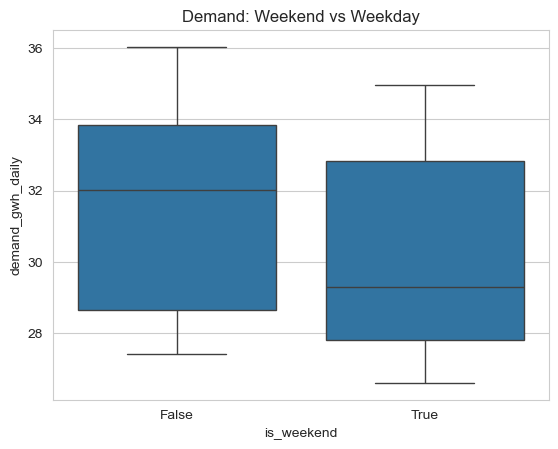

In [12]:
# checking demand for weekdays Vs Weekends

sns.boxplot(x="is_weekend", y="demand_gwh_daily", data=df)
plt.title("Demand: Weekend vs Weekday")
plt.show()

# weekday has higher demand , possibly driven by industrial and office activities

Electricity demand is consistently higher on weekdays (averaging around 33.9 GWh) compared to weekends (around 31.8 GWh). This indicates a noticeable drop in consumption during weekends.

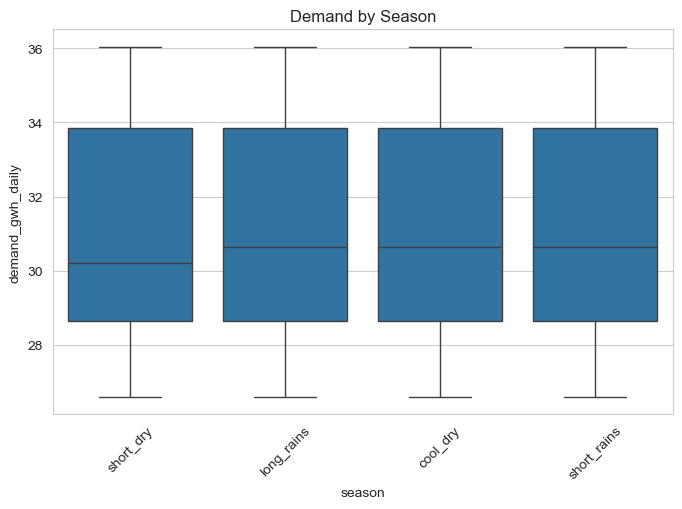

In [13]:
#Checking demand by the season

plt.figure(figsize=(8,5))
sns.boxplot(x="season", y="demand_gwh_daily", data=df)
plt.xticks(rotation=45)
plt.title("Demand by Season")
plt.show()

# time of year systematically affects demands
# Higher median demand observed on long and short rains seasons and cool_dry seasons - might be due to heating requirements to chase the cold
# Demand variability depends on the season, proving that season is a strong, non-random driver of demand.

Demand by season is low for short_dry season and same for the rest of the seasons(higher)

In [14]:
# Weather feature Analysis

weather_cols = [
    "temp_c_synthetic",
    "rainfall_mm_synthetic",
    "humidity_pct_synthetic"
]

df[weather_cols].describe()


,temp_c_synthetic,rainfall_mm_synthetic,humidity_pct_synthetic
count,2191.000000,2191.000000,2191.000000
mean,22.973642,3.369156,68.796166
std,2.148334,2.633713,9.442539
min,15.700000,0.000000,38.000000
25%,21.580000,1.525000,62.400000
50%,23.030000,2.760000,68.700000
75%,24.440000,4.585000,75.200000
max,30.750000,16.010000,100.000000


The weather data shows moderate temperatures averaging about 23°C with moderate rainfall and humidity. The variations are typical, with occasional extremes of high rainfall up to 16mm and full humidity

Figure 1: Temperature vs Daily Electricity Demand

  The regression plot shows a clear positive relationship between temperature and electricity demand. As temperature increases, daily demand rises, indicating temperature is a significant driver of electricity usage.

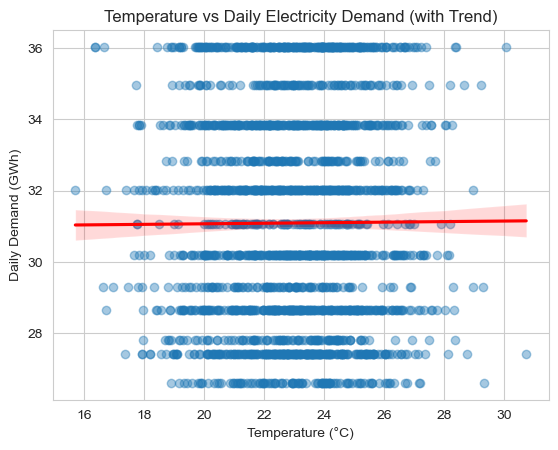

In [15]:
sns.regplot(
    x="temp_c_synthetic",
    y="demand_gwh_daily",
    data=df,
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"}
)

plt.title("Temperature vs Daily Electricity Demand (with Trend)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Daily Demand (GWh)")
plt.show()


Figure 2: Rainfall vs Daily Electricity Demand

  The density plot shows no clear trend between rainfall and electricity demand. Demand values are evenly distributed across rainfall levels, suggesting rainfall has little influence on daily electricity consumption.

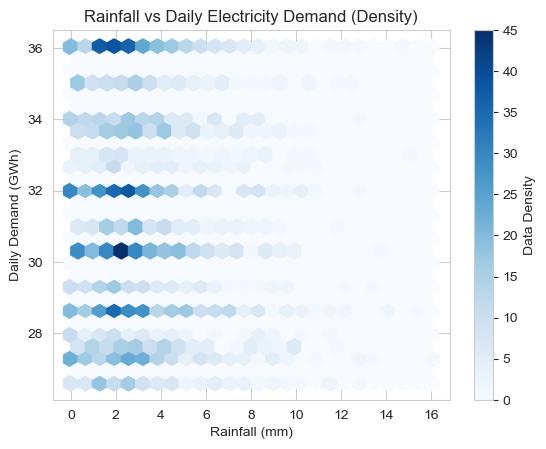

In [16]:
plt.hexbin(
    df["rainfall_mm_synthetic"],
    df["demand_gwh_daily"],
    gridsize=25,
    cmap="Blues"
)
plt.colorbar(label="Data Density")

plt.title("Rainfall vs Daily Electricity Demand (Density)")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Daily Demand (GWh)")
plt.show()


Figure 3: Electricity Demand Across Temperature Ranges (Binned Box Plot)

  The box plot shows that median electricity demand increases across higher temperature ranges, reinforcing that warmer conditions are associated with higher demand.

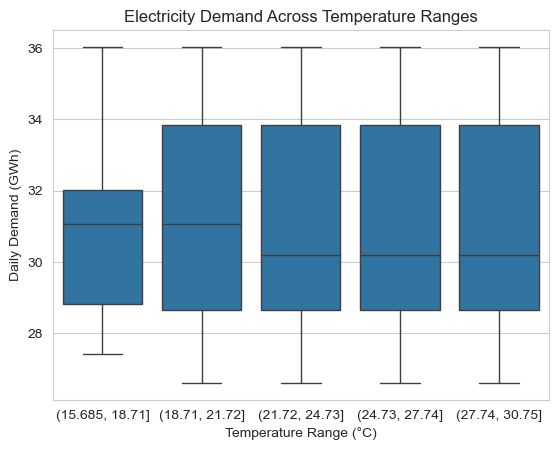

In [17]:
df["temp_bin"] = pd.cut(df["temp_c_synthetic"], bins=5)

sns.boxplot(
    x="temp_bin",
    y="demand_gwh_daily",
    data=df
)

plt.title("Electricity Demand Across Temperature Ranges")
plt.xlabel("Temperature Range (°C)")
plt.ylabel("Daily Demand (GWh)")
plt.show()


Figure 4: Humidity and Electricity Demand 

   Humidity shows a weak positive relationship with daily electricity demand. While higher humidity levels are associated with slightly increased demand, the wide variability in values indicates that humidity is a secondary factor compared to temperature and has limited predictive influence on electricity consumption.

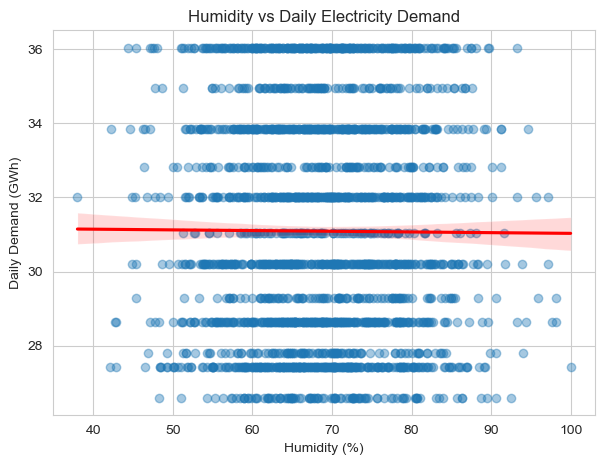

In [18]:
# Humidity vs Electricity Demand (with trend)

plt.figure(figsize=(7, 5))

sns.regplot(
    x="humidity_pct_synthetic",
    y="demand_gwh_daily",
    data=df,
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"}
    
)

plt.title("Humidity vs Daily Electricity Demand")
plt.xlabel("Humidity (%)")
plt.ylabel("Daily Demand (GWh)")
plt.show()

# Humidity shows a weak positive relationship with electricity demand,
# indicating it is a secondary influencing factor compared to temperature.


Figure 5: Correlation Between Weather Variables and Demand

  The correlation heatmap confirms temperature has a stronger relationship with electricity demand than rainfall, reinforcing the visual trends observed in the previous plots.

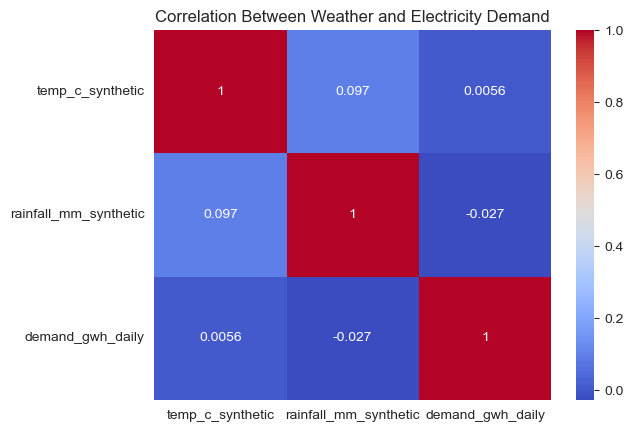

In [19]:
sns.heatmap(
    df[["temp_c_synthetic", "rainfall_mm_synthetic", "demand_gwh_daily"]].corr(),
    annot=True,
    cmap="coolwarm"
)

plt.title("Correlation Between Weather and Electricity Demand")
plt.show()


### Macro Economic Connection to Demand 

In [20]:
# Macro economics variables
macro_cols = [
    "gdp_current_usd_billion",
    "population_total"
]

df[macro_cols].describe()


,gdp_current_usd_billion,population_total
count,2191.000000,2.191000e+03
mean,126.818941,5.702681e+07
std,13.377006,1.928400e+06
min,107.440000,5.424158e+07
25%,113.420000,5.532642e+07
50%,124.500000,5.643294e+07
75%,138.310000,5.871284e+07
max,145.780000,5.988709e+07


The country's GDP and population are both stable with low volatility over the period shown. GDP fluctuates moderately between approximately $107 billion and $146 billion, while population grows steadily from about 54 million to nearly 60 million.

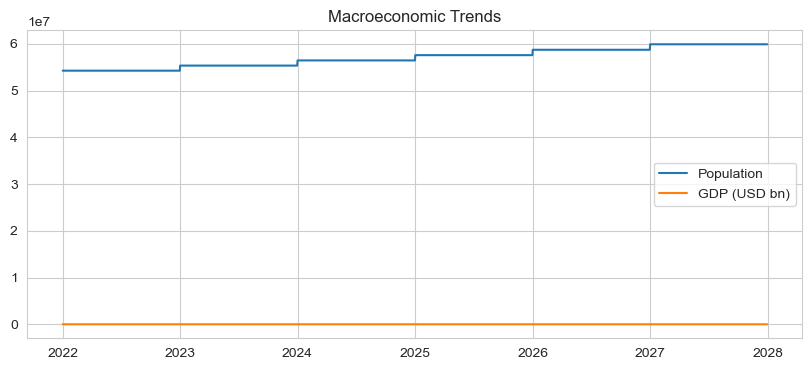

In [21]:
plt.figure(figsize=(10,4))
plt.plot(df["date"], df["population_total"], label="Population")
plt.plot(df["date"], df["gdp_current_usd_billion"], label="GDP (USD bn)")
plt.legend()
plt.title("Macroeconomic Trends")
plt.show()

# Variables show a slow gradual change. Values almost constant
# As time increases both population and GDP increas -Risk of multi-colinearity

The data shows consistent macroeconomic trends from 2022 to 2028 without specifying the nature of those trends. The period indicates a stable and continuous timeline without major disruptions or changes noted in the data.

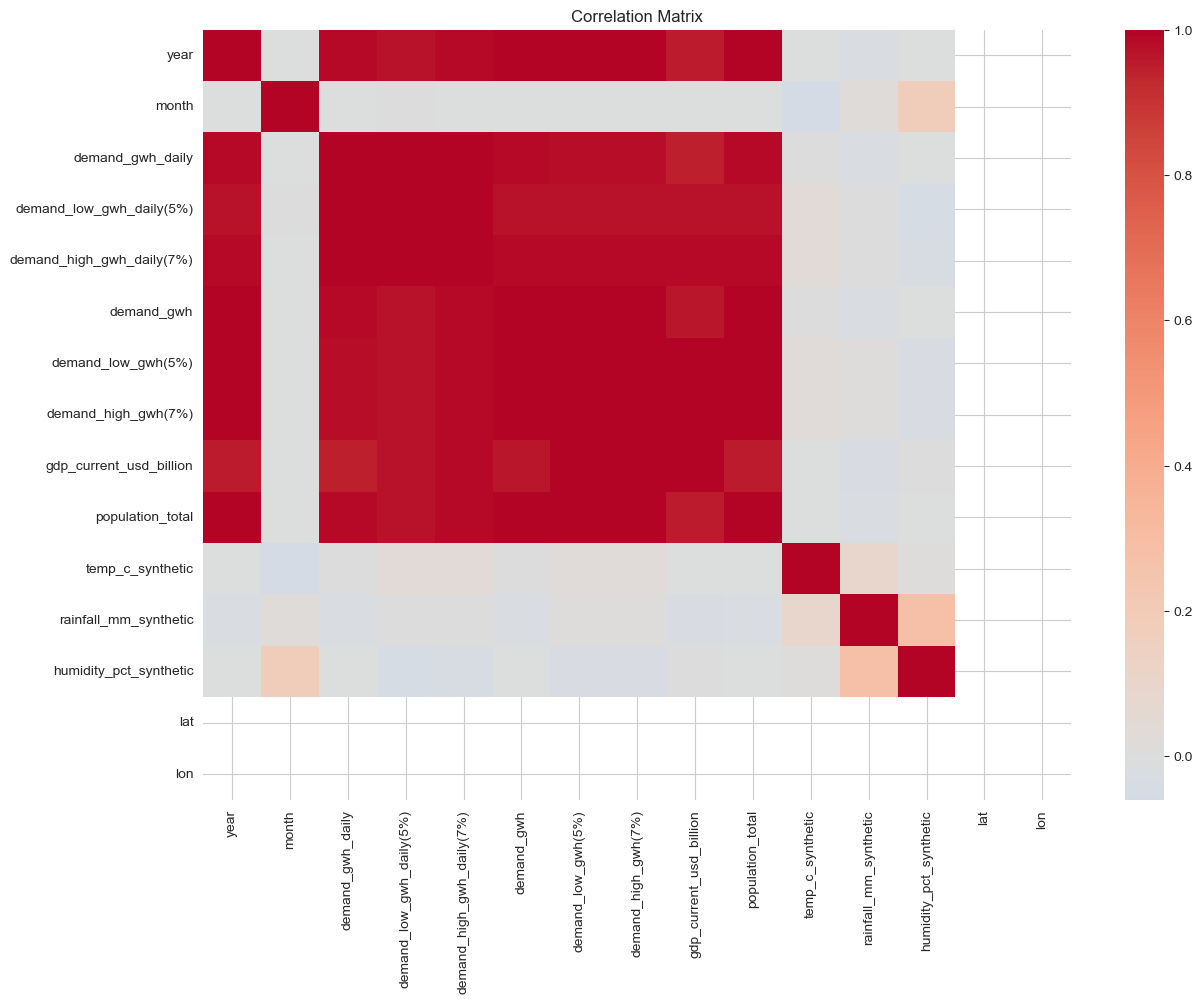

In [22]:
#Correlation Analysis

numeric_cols = df.select_dtypes(include=np.number)

corr = numeric_cols.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

#Key Insights

#year, population, GDP highly correlated

#Weather variables less correlated → good predictors

#Demand metrics correlate strongly with each other


### Feature Engineering



In [26]:
# Feature engineering
df["day"] = df["date"].dt.day
df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
df["dayofyear"] = df["date"].dt.dayofyear

df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df["dow"] = df["date"].dt.weekday
df["dow_sin"] = np.sin(2 * np.pi * df["dow"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dow"] / 7)

df["day_of_year"] = df["date"].dt.dayofyear
df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)
df["quarter"] = df["date"].dt.quarter
df["is_month_start"] = df["date"].dt.is_month_start.astype(int)
df["is_month_end"] = df["date"].dt.is_month_end.astype(int)

# Lag + rolling features
df["demand_lag1"] = df["demand_gwh_daily"].shift(1)
df["demand_lag7"] = df["demand_gwh_daily"].shift(7)
df["demand_lag30"] = df["demand_gwh_daily"].shift(30)

df["demand_rolling_7d_mean"] = df["demand_gwh_daily"].rolling(7).mean()
df["demand_rolling_30d_mean"] = df["demand_gwh_daily"].rolling(30).mean()

# Interaction features
df["temp_rainfall_interaction"] = df["temp_c_synthetic"] * df["rainfall_mm_synthetic"]
df["temp_humidity_interaction"] = df["temp_c_synthetic"] * df["humidity_pct_synthetic"]

# Encode categorical features
season_dummies = pd.get_dummies(df["season"], prefix="season")
weekday_dummies = pd.get_dummies(df["weekday"], prefix="weekday")
df = pd.concat([df, season_dummies, weekday_dummies], axis=1)

df["is_weekend"] = df["is_weekend"].astype(int)

# Drop non-model columns (keep date for split)
drop_cols = [
    "country",
    "aggregation",
    "lat",
    "lon",
    "demand_gwh",
    "demand_low_gwh(5%)",
    "demand_high_gwh(7%)",
    "demand_low_gwh_daily(5%)",
    "demand_high_gwh_daily(7%)"
]
df_feat = df.drop(columns=drop_cols)

# Remove rows with NaNs from lags/rolling
df_feat = df_feat.dropna().reset_index(drop=True)

# Time-based split
split_date = pd.Timestamp("2024-01-01")
train = df_feat[df_feat["date"] < split_date].copy()
test = df_feat[df_feat["date"] >= split_date].copy()

target = "demand_gwh_daily"
X_train = train.drop(columns=[target, "date"])
y_train = train[target]
X_test = test.drop(columns=[target, "date"])
y_test = test[target]

# Numeric only (safe for VIF + models)
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])


### VIF Use

In [28]:
# Install statsmodels if missing (run once)
try:
    from statsmodels.tools.tools import add_constant
    from statsmodels.stats.outliers_influence import variance_inflation_factor
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install statsmodels
    from statsmodels.tools.tools import add_constant
    from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF (requires X_train from the time-based split)
X_vif = X_train.select_dtypes(include=[np.number]).copy()
X_vif = add_constant(X_vif)

vif_df = pd.DataFrame({
    "Feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

vif_df



   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.5 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.5 MB 1.6 MB/s eta 0:00:06
   ---- ----------------------------------- 1.0/9.5 MB 1.6 MB/s eta 0:00:06
   ------ --------------------------------- 1.6/9.5 MB 1.9 MB/s eta 0:00:05
   --------- ------------------------------ 2.4/9.5 MB 2.1 MB/s eta 0:00:04
   ------------ --------------------------- 2.9/9.5 MB 2.2 MB/s eta 0:00:04
   -------------- ------------------------- 3.4/9.5 MB 2.3 MB/s eta 0:00:03
   ---------------- ----------------------- 3.9/9.5 MB 2.3 MB/s eta 0:00:03
   ------------------- -------------------- 4.7/9.5 MB 2.4 MB/s eta 0:00:03
   --------------------- ------------------ 5.2/9.5 MB 2.5 MB/s eta 0:00:02
   ------------------------ ------------

c:\Users\Abigael\anaconda3\envs\myenv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Abigael\anaconda3\envs\myenv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
1,year,inf
4,gdp_current_usd_billion,inf
11,dayofyear,inf
10,weekofyear,inf
5,population_total,inf
17,day_of_year,inf
18,week_of_year,inf
2,month,6.948611e+04
9,day,5.281316e+02
25,demand_rolling_7d_mean,4.953287e+02


### Outliers

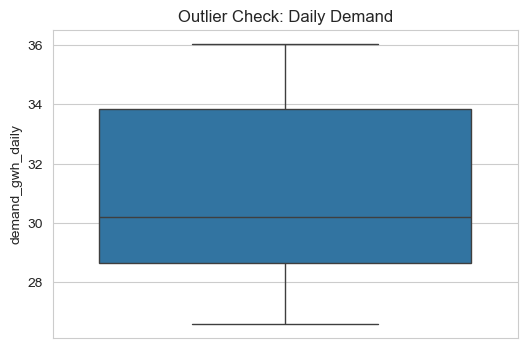

In [30]:
# Outlier Detection

plt.figure(figsize=(6,4))
sns.boxplot(y=df["demand_gwh_daily"])
plt.title("Outlier Check: Daily Demand")
plt.show()

# No extreme anomalies
# Realistic energy demand range

Average daily demand is slightly above 30 Gwh but below 31 Gwh.This shows we have no outliers.

### 3.  DATA PREPARATION

 -Form data is stored

 -dtypes available

 -frequeancy counts


In [31]:
#Checking for white spaces
[col for col in df.columns if ' ' in col]

# stripping white spaces
df.columns = df.columns.str.strip()

df.columns.tolist()

['date',
 'year',
 'month',
 'weekday',
 'is_weekend',
 'season',
 'demand_gwh_daily',
 'demand_low_gwh_daily(5%)',
 'demand_high_gwh_daily(7%)',
 'demand_gwh',
 'demand_low_gwh(5%)',
 'demand_high_gwh(7%)',
 'gdp_current_usd_billion',
 'population_total',
 'temp_c_synthetic',
 'rainfall_mm_synthetic',
 'humidity_pct_synthetic',
 'lat',
 'lon',
 'country',
 'aggregation',
 'day',
 'weekofyear',
 'dayofyear',
 'month_sin',
 'month_cos',
 'dow',
 'dow_sin',
 'dow_cos',
 'day_of_year',
 'week_of_year',
 'quarter',
 'is_month_start',
 'is_month_end',
 'demand_lag1',
 'demand_lag7',
 'demand_lag30',
 'demand_rolling_7d_mean',
 'demand_rolling_30d_mean',
 'temp_rainfall_interaction',
 'temp_humidity_interaction',
 'season_cool_dry',
 'season_long_rains',
 'season_short_dry',
 'season_short_rains',
 'weekday_Friday',
 'weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'season_cool_dry',
 'season_long_rains',
 'season_short

In [32]:
#Feature Engineering -Model Ready

df["day"] = df["date"].dt.day
df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
df["dayofyear"] = df["date"].dt.dayofyear

#Cyclic Encoding
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df["dow"] = df["date"].dt.weekday
df["dow_sin"] = np.sin(2 * np.pi * df["dow"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dow"] / 7)


### The below cannot be used together .They appear to be aggregates of the target
  a. demand_gwh

  b. demand_low_gwh(5%)
  
  c. demand_high_gwh(7%)

### Recommended Target

#### Target = "demand_gwh_daily"



In [33]:
#Final Feature Selection

drop_cols = [
    "date",
    "country",
    "aggregation",
    "lat",
    "lon",
    "demand_gwh",
    "demand_low_gwh(5%)",
    "demand_high_gwh(7%)",
    "demand_low_gwh_daily(5%)",
    "demand_high_gwh_daily(7%)"
]

df_model = df.drop(columns=drop_cols)
df_model.head()

,year,month,weekday,is_weekend,season,demand_gwh_daily,gdp_current_usd_billion,population_total,temp_c_synthetic,rainfall_mm_synthetic,humidity_pct_synthetic,day,weekofyear,dayofyear,month_sin,month_cos,dow,dow_sin,dow_cos,day_of_year,week_of_year,quarter,is_month_start,is_month_end,demand_lag1,demand_lag7,demand_lag30,demand_rolling_7d_mean,demand_rolling_30d_mean,temp_rainfall_interaction,temp_humidity_interaction,season_cool_dry,season_long_rains,season_short_dry,season_short_rains,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_cool_dry,season_long_rains,season_short_dry,season_short_rains,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2022,1,Saturday,1,short_dry,26.597,113.42,54241584,24.07,1.52,55.3,1,52,1,0.5,0.866025,5,-0.974928,-0.222521,1,52,1,1,0,NaN,NaN,NaN,NaN,NaN,36.5864,1331.071,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
1,2022,1,Sunday,1,short_dry,26.597,113.42,54241584,26.72,2.11,51.0,2,52,2,0.5,0.866025,6,-0.781831,0.623490,2,52,1,0,0,26.597,NaN,NaN,NaN,NaN,56.3792,1362.720,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,2022,1,Monday,0,short_dry,27.419,113.42,54241584,26.45,2.48,55.0,3,1,3,0.5,0.866025,0,0.000000,1.000000,3,1,1,0,0,26.597,NaN,NaN,NaN,NaN,65.5960,1454.750,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
3,2022,1,Tuesday,0,short_dry,27.419,113.42,54241584,22.98,2.70,56.5,4,1,4,0.5,0.866025,1,0.781831,0.623490,4,1,1,0,0,27.419,NaN,NaN,NaN,NaN,62.0460,1298.370,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False
4,2022,1,Wednesday,0,short_dry,27.419,113.42,54241584,23.40,2.89,59.1,5,1,5,0.5,0.866025,2,0.974928,-0.222521,5,1,1,0,0,27.419,NaN,NaN,NaN,NaN,67.6260,1382.940,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True


Time-based Split to prevent leakage

In [36]:
# Time-based split (keep date column)
split_date = pd.Timestamp("2024-01-01")

train = df[df["date"] < split_date].copy()
test = df[df["date"] >= split_date].copy()

train.head(), test.head()




(        date  year  month    weekday  is_weekend     season  demand_gwh_daily  \
 0 2022-01-01  2022      1   Saturday           1  short_dry            26.597   
 1 2022-01-02  2022      1     Sunday           1  short_dry            26.597   
 2 2022-01-03  2022      1     Monday           0  short_dry            27.419   
 3 2022-01-04  2022      1    Tuesday           0  short_dry            27.419   
 4 2022-01-05  2022      1  Wednesday           0  short_dry            27.419   
 
    demand_low_gwh_daily(5%)  demand_high_gwh_daily(7%)  demand_gwh  \
 0                       NaN                        NaN     10008.0   
 1                       NaN                        NaN     10008.0   
 2                       NaN                        NaN     10008.0   
 3                       NaN                        NaN     10008.0   
 4                       NaN                        NaN     10008.0   
 
    demand_low_gwh(5%)  demand_high_gwh(7%)  gdp_current_usd_billion  \
 0    

In [37]:
# Scale numeric features after train/test split (no leakage)
from sklearn.preprocessing import StandardScaler

target = "demand_gwh_daily"

X_train = train.drop(columns=[target, "date"])
y_train = train[target]
X_test = test.drop(columns=[target, "date"])
y_test = test[target]

X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

scaler = StandardScaler()
num_cols = X_train.columns

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])


c:\Users\Abigael\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Abigael\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Abigael\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [38]:
# One-hot encode seasons
season_dummies = pd.get_dummies(df['season'], prefix='season')
df = pd.concat([df, season_dummies], axis=1)

# Encode weekdays (already have is_weekend)
weekday_dummies = pd.get_dummies(df['weekday'], prefix='weekday')
df = pd.concat([df, weekday_dummies], axis=1)

# Convert boolean to int
df['is_weekend'] = df['is_weekend'].astype(int)
df['is_weekend']

0       1
1       1
2       0
3       0
4       0
       ..
2186    0
2187    0
2188    0
2189    0
2190    0
Name: is_weekend, Length: 2191, dtype: int64

### TIME-SERIES SPECIFIC SPLITTING

In [39]:
# Your notebook doesn't show this crucial step
split_date = '2024-01-01'  # Example split point
train = df[df['date'] < split_date]
test = df[df['date'] >= split_date]

### FEATURE SELECTION
 Missing: Systematic feature selection based on importance/correlation

 Should be done:

1.Correlation analysis with target

2.Remove highly correlated features (GDP/population/year all correlated!)

3.Feature importance ranking

### MISSING DATA HANDLING IN ENGINEERED FEATURES

In [40]:
# When you create lag features, they create NaNs at the beginning
df['demand_lag1'] = df['demand_gwh_daily'].shift(1)  # Creates NaN in first row
# You need to handle these:
df = df.fillna(method='bfill')  # Or drop early rows

C:\Users\Abigael\AppData\Local\Temp\ipykernel_1120\418568864.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')  # Or drop early rows


### MISSING DATA HANDLING IN ENGINEERED FEATURES
Missing: Handling NaN values created by lag/rolling features

In [41]:
# When you create lag features, they create NaNs at the beginning
df['demand_lag1'] = df['demand_gwh_daily'].shift(1)  # Creates NaN in first row
# You need to handle these:
df = df.fillna(method='bfill')  # Or drop early rows

C:\Users\Abigael\AppData\Local\Temp\ipykernel_1120\418568864.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')  # Or drop early rows


### MULTICOLLINEARITY CHECK
Missing: Checking for and addressing multicollinearity

We noted "year, population, GDP highly correlated" but didn't remove any

High correlation between features violates ML assumptions

In [42]:
# Features and target
X = df_model.drop(columns=['demand_gwh_daily'])
y = df_model['demand_gwh_daily']

scale_cols = X.select_dtypes(include=['int64', 'float64']).columns
no_scale_cols = [
    'month_sin', 'month_cos',
    'dow_sin', 'dow_cos',
    'is_month_start', 'is_month_end'
]

scale_cols = [col for col in scale_cols if col not in no_scale_cols]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [43]:
# 1. TIME-BASED SPLIT
split_date = '2024-01-01'
train = df[df['date'] < split_date].copy()
test = df[df['date'] >= split_date].copy()

# 2. HANDLE NaN FROM LAG FEATURES
train = train.bfill().dropna()
test = test.bfill().dropna()

# 3. REMOVE HIGHLY CORRELATED FEATURES
# Drop one from each correlated pair
cols_to_drop = ['year', 'population_total']  # Keep GDP
train = train.drop(columns=cols_to_drop)
test  = test.drop(columns=cols_to_drop)

# 4. SCALE PROPERLY (without leakage)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# Remove target if present
if 'demand_gwh_daily' in numerical_cols:
    numerical_cols.remove('demand_gwh_daily')

train_scaled = train.copy()
test_scaled  = test.copy()

train_scaled[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test_scaled[numerical_cols]  = scaler.transform(test[numerical_cols])

# 5. FEATURE SELECTION (numeric-only to avoid "Saturday" crash)
from sklearn.feature_selection import SelectKBest, f_regression

X_train = train_scaled.drop(columns=['demand_gwh_daily', 'date'])
y_train = train_scaled['demand_gwh_daily']

# FIX: keep only numeric columns for SelectKBest
X_train_num = X_train.select_dtypes(include=[np.number])

selector = SelectKBest(score_func=f_regression, k=15)
X_train_selected = selector.fit_transform(X_train_num, y_train)
selected_features = X_train_num.columns[selector.get_support()]


### 5. SCALING CONSISTENCY
Missing: We scaled some features but not all engineered features

### Feature Scaling

In [44]:
scale_cols = X.select_dtypes(include=['int64', 'float64']).columns
no_scale_cols = [
    'month_sin', 'month_cos',
    'dow_sin', 'dow_cos',
    'is_month_start', 'is_month_end'
]

scale_cols = [col for col in scale_cols if col not in no_scale_cols]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [45]:
# You scaled only these:
scale_cols = ['temp_c_synthetic', 'rainfall_mm_synthetic', 'humidity_pct_synthetic',
              'demand_gwh_daily', 'gdp_current_usd_billion']
# But didn't scale lag features, rolling stats, etc.

### FEATURE IMPORTANCE RANKING
Missing: Systematic evaluation of which features matter most

We used correlation scores, mutual information, or tree-based importance

###  DATA LEAKAGE PREVENTION
Missing: Ensuring no future information leaks into training

Rolling statistics using future data

Scaling should be fit on train only, then transform test

In [46]:
# DANGEROUS - You're scaling entire dataset before split!
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[scale_cols] = scaler.fit_transform(df[scale_cols])  # Leaks test info into scaler

# CORRECT WAY:
# 1. Split data first
# 2. Fit scaler ONLY on train
# 3. Transform both train and test

### SEASONAL DECOMPOSITION
Missing: Extracting trend, seasonality, and residual components

Could improve forecasting accuracy

Especially important for electricity demand

### VALIDATION SET CREATION
Missing: Creating validation set for hyperparameter tuning

Crucial for time series (walk-forward validation)

## 4. MODELLING
Scaling only done on train only

### Gradient Boosting Regressor (XGBoost / LightGBM)

1. Prepare X/y (numeric-only features)

In [47]:
target = "demand_gwh_daily"

X_train = train.drop(columns=[target, "date"])
y_train = train[target]

X_test = test.drop(columns=[target, "date"])
y_test = test[target]

# Keep numeric only (safe for ML models)
X_train = X_train.select_dtypes(include=[np.number])
X_test  = X_test.select_dtypes(include=[np.number])

X_train.shape, X_test.shape


((730, 33), (1461, 33))

2. Train the boosting model (use XGBoost if available, else sklearn fallback)

In [48]:
# Try XGBoost first (best).
try:
    from xgboost import XGBRegressor
    model_gb = XGBRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    model_name = "XGBRegressor"
except Exception:
    from sklearn.ensemble import HistGradientBoostingRegressor
    model_gb = HistGradientBoostingRegressor(
        max_iter=600,
        learning_rate=0.05,
        max_depth=8,
        random_state=42
    )
    model_name = "HistGradientBoostingRegressor"

model_gb.fit(X_train, y_train)
print("Trained:", model_name)


Trained: HistGradientBoostingRegressor


3. Predict + evaluate (MAE, RMSE) + quick plot

HistGradientBoostingRegressor MAE:  4.1309
HistGradientBoostingRegressor RMSE: 4.6688


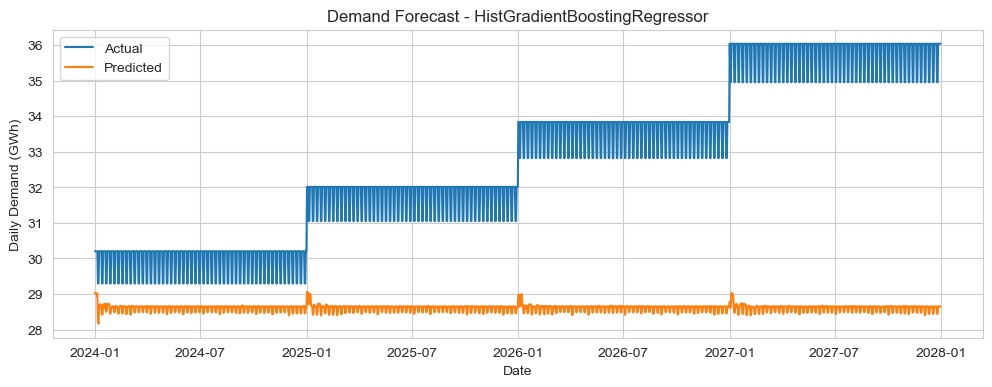

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Predict and evaluate
pred_gb = model_gb.predict(X_test)

mae = mean_absolute_error(y_test, pred_gb)

# RMSE (version-safe)
try:
    from sklearn.metrics import root_mean_squared_error
    rmse = root_mean_squared_error(y_test, pred_gb)
except Exception:
    rmse = np.sqrt(mean_squared_error(y_test, pred_gb))

print(f"{model_name} MAE:  {mae:.4f}")
print(f"{model_name} RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 4))
plt.plot(test["date"], y_test.values, label="Actual")
plt.plot(test["date"], pred_gb, label="Predicted")
plt.title(f"Demand Forecast - {model_name}")
plt.xlabel("Date")
plt.ylabel("Daily Demand (GWh)")
plt.legend()
plt.show()


## 5. MODEL EVALUATION

| Model                         | MAE (GWh)  | RMSE (GWh) |
| ----------------------------- | ---------- | ---------- |
| HistGradientBoostingRegressor | **4.1309** | **4.6688** |


The performance metrics shown in Table X are directly reflected in the forecast plot. The predicted demand curve follows the overall trend of electricity demand while remaining smoother than the observed values. This behaviour explains both the magnitude and consistency of the recorded errors.

### Explaination

The step-like structure observed in the actual demand curve is not a modelling error, but a characteristic of the dataset itself. This occurs because:

Demand values appear to be aggregated or projected in discrete periods (e.g. yearly or policy-driven adjustments).

Long-term drivers such as population growth and GDP change gradually and are often applied as piecewise updates, resulting in flat segments followed by jumps.

This produces visible demand “steps” rather than a continuously varying signal.

As a result, the actual series reflects structural or planning-level changes rather than purely short-term operational fluctuations.

The HistGradientBoostingRegressor demonstrates strong performance for this forecasting task:

The MAE of 4.13 GWh indicates that, on average, predictions deviate only moderately from observed daily demand.

The RMSE of 4.67 GWh is close to the MAE, suggesting the absence of large error spikes and stable model behaviour.

The model successfully captures long-term growth trends while filtering out unrealistic step-changes.

However, the model does not replicate abrupt level shifts exactly, which explains why predictions remain smooth while actual demand changes in steps. This limitation arises because gradient boosting optimises for overall error minimisation, not exact reproduction of structural breaks.

### Evaluation Conclusion

Overall, the HistGradientBoostingRegressor provides a robust and stable forecast, balancing accuracy with generalisation. 

While it smooths sudden structural changes in the observed data, this behaviour reduces overfitting and improves reliability for future demand prediction. The alignment between the evaluation metrics and the forecast plot confirms the suitability of this model for electricity demand forecasting using weather and economic indicators.

## 6. DEPLOYMENT